<a href="https://colab.research.google.com/github/Bala-Vignesh-S-M/Optic-disc/blob/main/Optic_disc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

input image


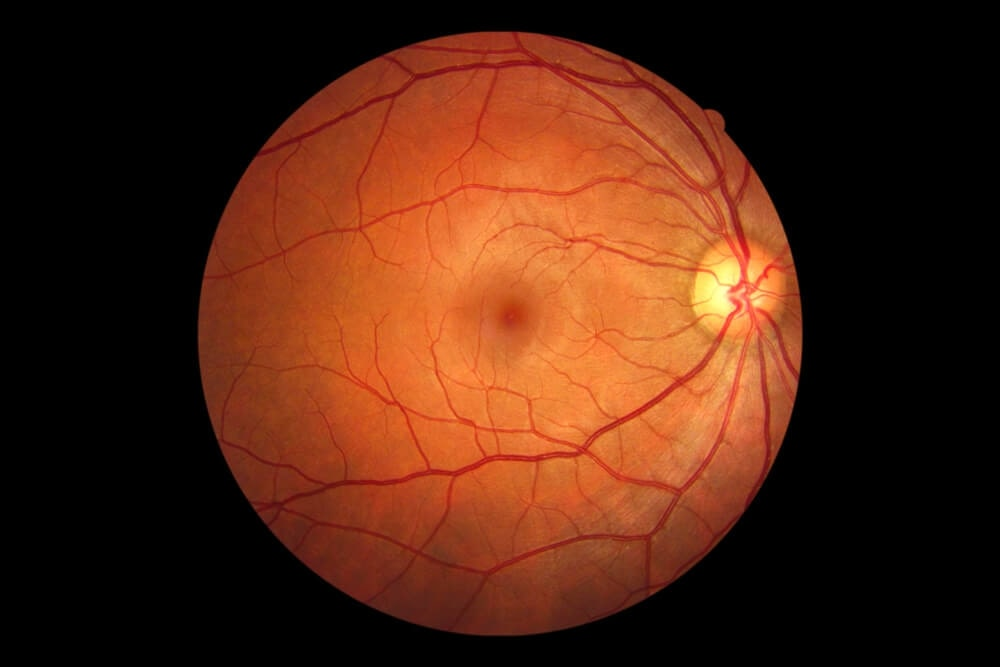

preprocessed image of range of interest


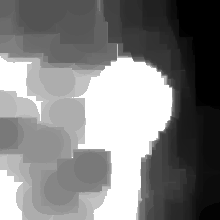

output image with detection of optic disc(denoted in blue circle)


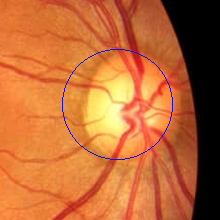

In [ ]:
import numpy as np
import scipy as sp
import scipy.ndimage as ndimage
import math
from skimage import exposure, filters
from matplotlib import pyplot as plt
import cv2
import matplotlib.pyplot as plt
from skimage.transform import hough_circle, hough_circle_peaks, hough_ellipse
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.segmentation import active_contour
from skimage.filters import gaussian
import argparse
from google.colab.patches import cv2_imshow


def resize(img):
    width = 1024
    height = 720
    return cv2.resize(img, (width, height), interpolation=cv2.INTER_CUBIC)


def rgb2Blue(img):
    b, g, r = cv2.split(img)
    return b


def rgb2Red(img):
    b, g, r = cv2.split(img)
    return r


def rgb2Green(img):
    b, g, r = cv2.split(img)
    return g


def rgb2Gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def rgb2lab(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2LAB)


#############preprocess###########
#Image is split on B,G,R channel
#Red channel is isolated
#Smoothing over the red channel is applied
#Sharpening and Equalization to te image are applied
#A morph closing is applied to remove artifacts
def preprocess(img):
    b, g, r = cv2.split(img)
    gray = rgb2Red(img)
    gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)
    gray = cv2.addWeighted(gray, 1.5, gray_blur, -0.5, 0, gray)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31, 31))
    gray = ndimage.grey_closing(gray, structure=kernel)
    gray = cv2.equalizeHist(gray)

    return gray


#############getROI##############
#Image is resized
#We take green channel and smooth it
#Opening is done to remove artifacts, in order to preserve only BRIGHTEST elements
#Now we get the most bright pixel position
#We return that position in a 110x110 window
#It is actually a simple way to detect the optic disc, but it works so..

def getROI(image):
    image_resized = resize(image)
    b, g, r = cv2.split(image_resized)
    g = cv2.GaussianBlur(g, (15, 15), 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    g = ndimage.grey_opening(g, structure=kernel)
    (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(g)

    x0 = int(maxLoc[0]) - 110
    y0 = int(maxLoc[1]) - 110
    x1 = int(maxLoc[0]) + 110
    y1 = int(maxLoc[1]) + 110

    return image_resized[y0:y1, x0:x1]


def getValue(img):
    shapeRow = img.shape[0]
    shapeCol = img.shape[1]
    x = 0
    y = 0
    acu = 0
    maxloc = []
    for i in range(shapeRow):
        for j in range(shapeCol):
            (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(img[i - 15:j - 15, i + 15:j + 15])
            value = maxVal
            if value > acu:
                acu = value
                maxloc = maxLoc
    return maxloc


def kmeans(img):
    ## K-Means
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    roi = img
    X = roi.reshape((-1, 1))
    X = np.float32(X)
    compactness, labels, centers = cv2.kmeans(X, 3, None, criteria, 10, flags)

    result = np.choose(labels, centers)
    result.shape = X.shape

    centers = np.uint8(centers)
    res = centers[labels.flatten()]
    res2 = res.reshape((roi.shape))
    return res2


def checkSide(img):
    shapeRow = img.shape[0]
    shapeCol = img.shape[1]
    if cv2.countNonZero(img[:, 0:int(shapeCol / 2)]) > cv2.countNonZero(img[:, int(shapeCol / 2):shapeCol]):
        return True
    else:
        return False


def checkHigh(img):
    shapeRow = img.shape[0]
    shapeCol = img.shape[1]
    if cv2.countNonZero(img[0:int(shapeRow / 2), :]) > cv2.countNonZero(img[int(shapeRow / 2):shapeRow, :]):
        return True
    else:
        return False


def canny(img, sigma):
    v = np.mean(img)
    sigma = sigma
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(img, lower, upper)
    return edged


def hough(edged, limm, limM):
    hough_radii = np.arange(limm, limM, 1)
    hough_res = hough_circle(edged, hough_radii)
    return hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)



#Here we start the process

image = cv2.imread('IMG_NAME.jpg')
print('input image')
cv2_imshow(image)
roi = getROI(image)
preprocessed_roi = preprocess(roi)

# im2, contours, hierarchy = cv2.findContours(segmented, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
##We get our ROI and then we preprocess it.
##After preprocess, we apply a canny border algorithm
##We dilate the borders in order to make it easy to detect with hough

edged = canny(preprocessed_roi, 0.22)
kernel = np.ones((3, 3), np.uint8)
edged = cv2.dilate(edged, kernel, iterations=3)
accums, cx, cy, radii = hough(edged, 55, 80)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius)
    try:
        roi[circy, circx] = (220, 20, 20)
    except:
        continue

init = np.array([circx, circy]).T

print('preprocessed image of range of interest')
cv2_imshow(preprocessed_roi)
print('output image with detection of optic disc(denoted in blue circle)')
cv2_imshow(roi)
